# Lab 3d: The XOR Problem
In this lab, we'll represent datasets with different separability properties, train Perceptron and Logistic Regression classifiers on both linearly separable and non-linearly separable data, and analyze their performance on [the XOR dataset](https://en.wikipedia.org/wiki/Exclusive_or) to understand the fundamental limitations of linear classifiers.

* __Backstory__: In 1969, AI researchers [Marvin Minsky](https://en.wikipedia.org/wiki/Marvin_Minsky) and [Seymour Papert](https://en.wikipedia.org/wiki/Seymour_Papert) published a book called [Perceptrons](https://en.wikipedia.org/wiki/Perceptrons_(book)), in which they argued that [the perceptron built by Rosenblatt](https://en.wikipedia.org/wiki/Perceptron) was incapable of learning certain functions, one of those being [the XOR function](https://en.wikipedia.org/wiki/Exclusive_or). Soon after [Perceptrons](https://en.wikipedia.org/wiki/Perceptrons_(book)) was published, the first [AI winter](https://en.wikipedia.org/wiki/AI_winter) began. Are these events correlated, maybe!

First, let's build and analyze datasets that _should work_, i.e., they are (nearly) linearly separable, and then we'll explore datasets that we know for sure _will not work_, i.e., they are not linearly separable, and see what happens.  

> __Learning Objectives:__
>
> By the end of this lab, you will be able to:
>
> * __Understand the concept of linear separability and its impact on classifier performance:__ Recognize how dataset geometry determines whether linear classifiers can achieve perfect separation and why certain patterns like XOR are inherently non-separable by linear decision boundaries.
> * __Build and train Perceptron and Logistic Regression models:__ Implement both classification algorithms, apply online learning and gradient descent methods to estimate model parameters from training data, and use trained models to predict labels on unseen test data.
> * __Evaluate classifier performance using confusion matrices:__ Compute and interpret confusion matrices to quantify classification accuracy, identify misclassified samples, and understand the relationship between data separability and model performance limitations.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

__Instructions:__ Uncomment the code below to include `Include.jl` and set up the environment.


In [1]:
#=
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file
=#

In addition to standard Julia libraries, we'll also use [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). Check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types, and data used in this material.

### Constants
Next, let's set some constants we'll need for the data generation logic below. Please look at the comment next to the constant for a description of what it is, permissible values, etc.

__Instructions:__ Uncomment the code below to define the constants used for data generation.


In [2]:
#=
number_label_one = 1000; # number of points in cloud 1 (must be ≥ 2)
number_label_two = 1000; # number of points in cloud 2 (must be ≥ 2)
total_number_of_points = (number_label_one + number_label_two);
number_of_features = 3; # features: (x,y,l), where l is a generated label; see below.
c̄₁ = (0.0, 0.0); # center for the cloud: fixed
θ = 60*(π/180); # rotation angle (radians)
T = 1.0; # inverse temperature parameter
=#

Finally, let's set up the color dictionary to visualize the classification datasets. The keys of the `my_color_dictionary::Dict Int64, RGB` dictionary are class labels, i.e., $ y\in\{1,-1\}$ while the values are the colors mapped to that label.

__Instructions:__ Uncomment the code below to define the label color dictionary.


In [3]:
#=
my_color_dictionary = Dict{Int64,RGB}();
my_color_dictionary[1] = colorant"#03045e"; # color for Label = 1
my_color_dictionary[-1] = colorant"#e36414"; # color for Label = -1
=#

### Implementation
Before generating our synthetic dataset, we need to define helper functions for data generation and quality assessment. These functions will generate circular data clouds, create circle boundaries for visualization, and compute silhouette scores to evaluate clustering quality.

__Instructions:__ Uncomment the code below to define `fixedcircle(...)`.


In [4]:
#=
"""
    fixedcircle(center::Tuple{Float64,Float64}; number_of_points::Int = 100, radius::Float64 = 1.0) -> Array{Float64,2}

Generate random data points around a center point that lie on a circle.

### Arguments
- `center::Tuple{Float64, Float64}`: The center point around which the data points will be generated.
- `number_of_points::Int = 100`: The number of data points to generate.
- `radius::Float64 = 1.0`: The radius of the circle around the center point. Default value is 1.0.

### Returns
- A 2D array of data points. The first two columns are the x and y coordinates of the data points.
"""
function fixedcircle(center::Tuple{Float64,Float64}; 
    number_of_points::Int = 100, radius::Float64 = 1.0)::Array{Float64,2}

    # initialize -
    data = zeros(number_of_points, 2);
    θ = range(0, 2π, length=number_of_points);

    # generate the data -
    for i ∈ 1:number_of_points
        # generate random data points -
        data[i,1] = center[1] + radius * cos(θ[i]); # x
        data[i,2] = center[2] + radius * sin(θ[i]); # y
    end

    # return -
    return data;
end;
=#

The `fixedcircle(...)` function generates evenly spaced points on a circle boundary for visualization purposes. We'll use this to overlay circle boundaries on our plots to show the true extent of each data cloud.

Next, let's define the data generation function:

__Instructions:__ Uncomment the code below to define `generatedatacloud(...)`.


In [5]:
#=
"""
    generatedatacloud(center::Tuple{Float64,Float64}; number_of_points::Int = 100, radius::Float64 = 1.0, label::Int64 = 1) -> Array{Float64,2}

Generate random data points around a center point that have a label, and radius less than equal to the given radius.

### Arguments
- `center::Tuple{Float64,Float64}`: The center point around which the data points will be generated.
- `number_of_points::Int = 100`: The number of data points to generate.
- `radius::Float64 = 1.0`: The radius of the circle around the center point. Default value is 1.0.
- `label::Int64 = 1`: The label to assign to the data points. Default value is 1.

### Returns
- A 2D array of data points. The first two columns are the x and y coordinates of the data points, and the third column is the label.
"""
function generatedatacloud(center::Tuple{Float64,Float64}; 
    number_of_points::Int = 100, radius::Float64 = 1.0, label::Int64 = 1)::Array{Float64,2}

    # initialize -
    data = zeros(number_of_points, 3);

    # generate the data -
    for i ∈ 1:number_of_points
        
        θ = rand() * 2π; # random angle
        r = rand() * radius; # random radius

        # generate random data points -
        data[i,1] = center[1] + r * cos(θ); # x
        data[i,2] = center[2] + r * sin(θ); # y
        data[i,3] = label; # label
    end

    # return -
    return data;
end;
=#

### Data
We'll use [the Perceptron (Rosenblatt, 1957)](https://en.wikipedia.org/wiki/Perceptron) and [Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) to classify datasets, including [the XOR dataset](https://en.wikipedia.org/wiki/Exclusive_or) that we construct. First, we'll generate a master dataset (which may or may not be linearly separable), and then we'll split it into `training` and `test` subsets.
* __Training data__: Training datasets are collections of labeled data used to teach machine learning models, allowing these tools to learn patterns and relationships within the data. In our case, we'll use the training data to estimate the classifier parameters $\beta$.
* __Test data__: Test datasets, on the other hand, are separate sets of labeled data used to evaluate the performance of trained models on unseen examples, providing an unbiased assessment of the _model's generalization capabilities_.

Let's start with the master dataset `D::Array{Float64,2}`. This dataset will have two continuous features $\mathbf{x}\in\mathbb{R}^{2}$ and a categorical label $y\in\{-1,1\}$. We'll build a label function $L:\mathbb{R}\times\mathbb{R}\to\{\text{true, false}\}$ (we can change this function around to get different labeling patterns):

__Instructions:__ Uncomment exactly one labeling function below to choose the labeling pattern for `D`.


In [6]:
#=
# TODO: uncomment this logic for different labeling patterns
# L(x,y) = (y ≥ 0) ? true : false; # rotated half circle (linearly separable)
L(x,y) = (x ≥ 0) && (y ≥ 0) ? true : false; # wedge pattern (not linearly separable)
# L(x,y) = xor(x ≥ 0,y ≥ 0); # XOR pattern alternating pie wedges (not linearly separable)
=#

L (generic function with 1 method)

Generate the master dataset `D`:

__Instructions:__ Uncomment the code below to generate the master dataset `D`.


In [7]:
#=
D = let
    
    # initialize -
    D = Array{Float64,2}(undef, total_number_of_points, number_of_features);
    s₁ = generatedatacloud(c̄₁, number_of_points = number_label_one, label=0); # generate label 1 data
    s₂ = generatedatacloud(c̄₁, number_of_points = number_label_two, label=0); # generate label 2 data

    # mix s₁, s₂ together (randomly)
    tmp = vcat(s₁,s₂)
    random_perm_index_vector = randperm(total_number_of_points);
    for i ∈ eachindex(random_perm_index_vector)
        k = random_perm_index_vector[i]; # get the from col -
        for j ∈ 1:number_of_features
            D[i,j] = tmp[k,j];
        end
    end

    # compute the label by taking the XOR, OR, AND, etc functions
    for i ∈ 1:total_number_of_points
        flag = L(D[i,1],D[i,2]);
        if (flag == true)
            D[i,3] = 1
        else
            D[i,3] = -1
        end
    end

    # finally, let's rotate the data a bit (counter-clockwise)
    R = [
        cos(θ) -sin(θ) ;
        sin(θ) cos(θ) ;
    ];

    # keep the label, but apply the rotation the (x,y) data
    D̂ = copy(D);
    for i ∈ 1:total_number_of_points
        x̂ = R*D[i,1:2];
        D̂[i,1] = x̂[1];
        D̂[i,2] = x̂[2];
    end
    
    D̂ # return the data
end;
=#

#### Visualize dataset `D`
`Uncomment` the code block below to see how we plotted the dataset `D` which contains two continuous features and a label. The color indicates the label.

> __Summary__: We will get a different pattern of $\pm{1}$ labels depending on the labeling function logic $L(x_{1},x_{2})$ we used. The dark blue dots represent label `1`, while the orange data represents label `-1`. Our classifier should be able to learn the mapping between the features and the labels for linearly separable datasets.

So what do we see?

__Instructions:__ Uncomment the code below to visualize the dataset `D`.


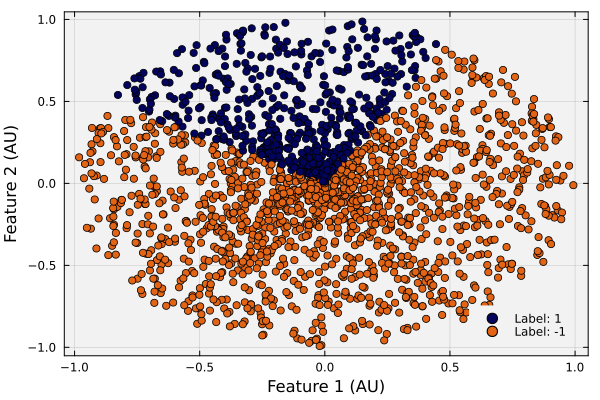

In [8]:
#=
let

    dataset = D; # what dataset am I looking at?
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot

    # plot label = 1
    testlabel = 1;
    i = findfirst(label -> label == testlabel,  dataset[:,3])
    c = my_color_dictionary[testlabel]
    scatter!([dataset[i,1]], [dataset[i,2]], label="Label: $(testlabel)", c=c)

    # plot label = -1
    testlabel = -1;
    i = findfirst(label -> label == testlabel,  dataset[:,3])
    c = my_color_dictionary[testlabel]
    scatter!([dataset[i,1]], [dataset[i,2]], label="Label: $(testlabel)", c=c)

    # plot all points
    for i ∈ 1:total_number_of_points
        label = dataset[i,3]; # label
        c = my_color_dictionary[label]
        scatter!([dataset[i, 1]], [dataset[i, 2]], label="", mec=:navy, c=c)
    end
    
    xlabel!("Feature 1 (AU)", fontsize=18);
    ylabel!("Feature 2 (AU)", fontsize=18);
end
=#

Next, let's split that dataset `D` into `training` and `test` subsets. We do this randomly, where the `number_of_training_examples::Int64` variable specifies the number of training points. The `training::Array{Float64,2}` data will be used to estimate the model parameters, and `test::Array{Float64,2}` will be used for model testing.

__Instructions:__ Uncomment the code below to split `D` into `training` and `test` sets.


In [9]:
#=
training, test = let

    number_of_training_examples = 1200; # we make this number of
    number_of_examples = total_number_of_points;
    perm = randperm(number_of_examples);
    training_index = perm[1:number_of_training_examples];
    test_index = perm[number_of_training_examples+1:end];

    # build the test and train datasets -
    training = D[training_index, :];
    test = D[test_index, :];

    # return
    training, test
end;
=#

___

## Task 1: Build a Perceptron Classification Model and Learn the Parameters
In this task, we'll build a model of our classification problem and train the model using an online learning method. 
* __Training__: Our Perceptron implementation [based on pseudo-code](https://github.com/varnerlab/CHEME-5820-Lectures-Spring-2025/blob/main/lectures/week-3/L3a/docs/Notes.pdf) stores problem information in [a `MyPerceptronClassificationModel` instance, which holds the (initial) parameters and other data](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/types/#VLDataScienceMachineLearningPackage.MyPerceptronClassificationModel) required by the problem. We initialize the parameters using a vector of `1`'s.
* Next, we then _learn_ the model parameters [using the `learn(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/binaryclassification/#VLDataScienceMachineLearningPackage.learn), which takes the training features array `X,` the training labels vector `y`, and the problem instance and returns an updated problem instance holding the updated parameters. 

We'll store information about the trained model in a variable called `perceptron_model::MyPerceptronClassificationModel`.

__Instructions:__ Uncomment the code below to build and train the perceptron model.

In [10]:
#=
perceptron_model = let
    
    # setup
    D = training; # what dataset are we going to use?
    number_of_examples = size(D,1); # how many examples do we have (rows)
    number_of_features = size(D,2); # how many features do we have (cols)?
    X = [D[:,1:end-1] ones(number_of_examples)]; # features, what??
    y = D[:,end]; # output: this is the target data (label)
    
    # build an initial model
    model = build(MyPerceptronClassificationModel, (
        parameters = ones(number_of_features),
        mistakes = 0 # willing to live with m mistakes
    ));

    # train the model -
    trainedmodel = learn(X,y,model, maxiter = 1000, verbose = true);

    # return -
    trainedmodel;
end;
=#

Stopped after number of iterations: 1000. We have number of errors: 232


__Inference__: Now that we have parameters estimated from the `training` data, we can use those parameters on the `test` dataset to see how well the model can differentiate between classes on data it has never seen. 

We run the classification operation on the (unseen) test data [using the `classify(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/binaryclassification/#VLDataScienceMachineLearningPackage.classify). This method takes a feature array `X` and the (trained) model instance. It returns the estimated labels. We store the actual (correct) label in the `y_perceptron::Array{Int64,1}` vector, while the model predicted label is stored in the `ŷ_perceptron::Array{Int64,1}` array.

__Instructions:__ Uncomment the code below to compute perceptron predictions on the test set.

In [11]:
#=
ŷ_perceptron,y_perceptron = let

    D = test; # what dataset are going to use?
    number_of_examples = size(D,1); # how many examples do we have (rows)
    number_of_features = size(D,2); # how many features do we have (cols)?
    X = [D[:,1:end-1] ones(number_of_examples)]; # features: need to add a 1 to each row (for bias), after removing the label
    y = D[:,end]; # output: this is the *actual* target data (label)

    # compute the estimated labels -
    ŷ = classify(X,perceptron_model)

    # return -
    ŷ,y
end;
=#

__Visualize the misses__. Using the test dataset, let's show (with gray circles) which samples our classifier is unable to predict the label correctly, i.e., where we miss the label.

__Instructions:__ Uncomment the code below to visualize perceptron classification misses.


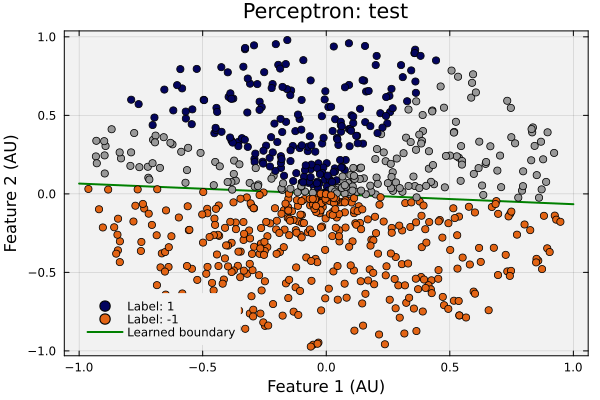

In [12]:
#=
let

    model = perceptron_model; # which model am I using?
    dataset = test; # what dataset am I looking at?
    caselabel = "test";
    actual = y_perceptron;
    predicted = ŷ_perceptron;
    number_of_points = size(dataset,1); # number of rows
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot
    
    # plot label = 1
    testlabel = 1;
    i = findfirst(label -> label == testlabel,  dataset[:,3])
    c = my_color_dictionary[testlabel]
    scatter!([dataset[i,1]], [dataset[i,2]], label="Label: $(testlabel)", c=c)

    # plot label = -1
    testlabel = -1;
    i = findfirst(label -> label == testlabel,  dataset[:,3])
    c = my_color_dictionary[testlabel]
    scatter!([dataset[i,1]], [dataset[i,2]], label="Label: $(testlabel)", c=c)

    # let's draw the separating hyperplane (in our case, a line)
    p = model.β;
    number_of_plane_points = 200;
    x₂ = zeros(number_of_plane_points);
    x₁ = range(-1,stop=1,length = number_of_plane_points) |> collect;
    for i ∈ 1:number_of_plane_points
        x₂[i] = -1*((p[1]/p[2])*x₁[i] + p[3]/p[2]);
    end
    plot!(x₁,x₂,lw=2, c=:green, label="Learned boundary")
    
    # data -
    for i ∈ 1:number_of_points
        actuallabel = actual[i]; # actual label
        testlabel = predicted[i]; # predited label

        c = :gray60;
        if (actuallabel == testlabel)
            c = my_color_dictionary[actuallabel]
        end
        scatter!([dataset[i, 1]], [dataset[i, 2]], label="", mec=:navy, c=c)
    end

    title!("Perceptron: $(caselabel)", fontsize=18)
    xlabel!("Feature 1 (AU)", fontsize=18);
    ylabel!("Feature 2 (AU)", fontsize=18);
end
=#

__Confusion matrix__: The confusion matrix is a $2\times{2}$ matrix that contains four entries: true positive (TP), false positive (FP), true negative (TN), and false negative (FN). Let's compute the confusion matrix [using the `confusion(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/binaryclassification/#VLDataScienceMachineLearningPackage.confusion) and store it in the `CM_perceptron::Array{Int64,2}` variable:

__Instructions:__ Uncomment the code below to compute the perceptron confusion matrix.

In [13]:
#=
CM_perceptron = confusion(y_perceptron, ŷ_perceptron)
=#

2×2 Matrix{Int64}:
 209    0
 192  399

Finally, we can compute the overall error rate for the perceptron (or other performance metrics) using values from [the confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). The [`confusion(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/binaryclassification/#VLDataScienceMachineLearningPackage.confusion) takes the actual labels and the computed labels and returns the confusion matrix.

__Instructions:__ Uncomment the code below to compute the perceptron accuracy.

In [14]:
#=
number_of_test_points = length(y_perceptron);
correct_prediction_perceptron = CM_perceptron[1,1] + CM_perceptron[2,2];
(correct_prediction_perceptron/number_of_test_points) |> f-> println("Fraction correct: $(f) Fraction incorrect $(1-f)")
=#

Fraction correct: 0.76 Fraction incorrect 0.24


___

## Task 2: Build and Train Logistic Regression Classification Model
In this task, we build and train a [Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) classifier using the training data, and then challenge this classifier using the `test` dataset. Unlike the Perceptron model, which outputs the class label directly, logistic regression models compute the _probability_ that a given input belongs to a particular class based on the input features. The training method is also different, we have to iteratively estimate the model parameters (in this case using [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent)).

We implemented [the `MyLogisticRegressionClassificationModel` type](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/types/#VLDataScienceMachineLearningPackage.MyLogisticRegressionClassificationModel), which contains data required to solve the logistic regression problem, i.e., parameters, the learning rate, a stopping tolerance parameter $\epsilon$, and a loss (objective) function that we want to minimize. 

> __Technical note__: We approximated the gradient calculation using [a forward finite difference](https://en.wikipedia.org/wiki/Finite_difference). This is generally not a great idea. This is one of my super pet peeves with gradient descent; computing the gradient is (usually) a hassle. Typically, we have to do at least two function evaluations to approximate the gradient well. Why do finite diference? It is easy to implement.

In the code below, we [build a `model::MyLogisticRegressionClassificationModel` instance using a `build(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/factory/#VLDataScienceMachineLearningPackage.build). The model instance initially has a random guess for the classifier parameters. We use gradient descent to refine that guess [using the `learn(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/binaryclassification/#VLDataScienceMachineLearningPackage.learn), which returns an updated model instance (with the best parameters that we found so far). We return the updated model instance and save it in the `model_logistic::MyLogisticRegressionClassificationModel` variable.

__Instructions:__ Uncomment the code below to build and train the logistic regression model.

In [15]:
#=
model_logistic = let

    # data -
    D = training; # What dataset are we going to use?
    number_of_examples = size(D,1); # how many examples do we have (rows)
    number_of_features = size(D,2); # how many features do we have (cols)?
    X = [D[:,1:end-1] ones(number_of_examples)]; # features: need to add a 1 to each row (for bias), after removing the label
    y = D[:,end]; # output: this is the target data (label)

    # model
    model = build(MyLogisticRegressionClassificationModel, (
        parameters = 0.01*ones(number_of_features), # initial value for the parameters: these will be updated
        learning_rate = 0.01, # you pick this
        ϵ = 1e-4, # you pick this (this is also the step size for the fd approx to the gradient)
        T = T, # inverse temperature parameter
        loss_function = (x,y,T,θ) -> log10(1+exp(-2*y*T*(dot(x,θ)))) # what??!? Wow, that is nice. Yes, we can pass functions as args!
    ));

    # train -
    model = learn(X,y,model, maxiter = 10000, verbose = true); # this is learning the model parameters

    # return -
    model;
end;
=#

Stopped after number of iterations: 10001. We have error: 33.01156076885084


Let's use the updated `model_logistic::MyLogisticRegressionClassificationModel` instance (with parameters learned from the `training` data) and test how well we can classify data in the `test` dataset.

> __Inference__: We run the classification operation on the (unseen) test data [using the `classify(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/binaryclassification/#VLDataScienceMachineLearningPackage.classify). This method takes a feature array `X` and the (trained) model instance. It returns the probability of a label in the `P::Array{Float64,2}` array (which is different than the Perceptron). Each row of `P` corresponds to a test instance, in which each column corresponds to a label, in the case `1` and `-1`.

We store the actual (correct) label in the `y_logistic::Array{Int64,1}` vector. We compute the predicted label for each test instance by finding the highest probability column. We store the predicted labels in the `ŷ_logistic::Array{Int64,1}` vector.

__Instructions:__ Uncomment the code below to compute logistic regression predictions.

In [16]:
#=
ŷ_logistic,y_logistic, P = let

    D = test; # What dataset are you going to use?
    number_of_examples = size(D,1); # how many examples do we have (rows)
    number_of_features = size(D,2); # how many features do we have (cols)?
    X = [D[:,1:end-1] ones(number_of_examples)]; # features: need to add a 1 to each row (for bias), after removing the label
    y = D[:,end]; # output: this is the *actual* target data (label)

    # compute the estimated labels -
    P = classify(X,model_logistic) # logistic regression returns a x x 2 array holding the probability

    # convert the probability to a choice ... for each row (test instance), compute the col with the highest probability
    ŷ = zeros(number_of_examples);
    for i ∈ 1:number_of_examples
        a = argmax(P[i,:]); # col index with largest value
        ŷ[i] = 1; # default
        if (a == 2)
            ŷ[i] = -1;
        end
    end
    
    # return -
    ŷ, y, P
end;
=#

__Visualize the misses__: Using the test dataset, we'll show (with gray circles) which samples the logistic regression classifier is unable to predict correctly.

__Instructions:__ Uncomment the code below to visualize logistic regression misses.


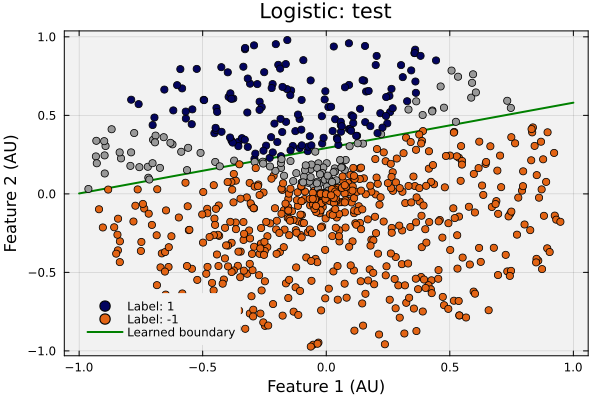

In [19]:
#=
let

    model = model_logistic; # which model am I using?
    dataset = test; # what dataset am I looking at?
    caselabel = "test";
    actual = y_logistic;
    predicted = ŷ_logistic;
    number_of_points = size(dataset,1); # number of rows
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot
    
    # plot label = 1
    testlabel = 1;
    i = findfirst(label -> label == testlabel,  dataset[:,3])
    c = my_color_dictionary[testlabel]
    scatter!([dataset[i,1]], [dataset[i,2]], label="Label: $(testlabel)", c=c)

    # plot label = -1
    testlabel = -1;
    i = findfirst(label -> label == testlabel,  dataset[:,3])
    c = my_color_dictionary[testlabel]
    scatter!([dataset[i,1]], [dataset[i,2]], label="Label: $(testlabel)", c=c)

    # let's draw the separating hyperplane (in our case, a line)
    p = model.β;
    number_of_plane_points = 200;
    x₂ = zeros(number_of_plane_points);
    x₁ = range(-1,stop=1,length = number_of_plane_points) |> collect;
    for i ∈ 1:number_of_plane_points
        x₂[i] = -1*((p[1]/p[2])*x₁[i] + p[3]/p[2]);
    end
    plot!(x₁,x₂,lw=2, c=:green, label="Learned boundary")
    
    # data -
    for i ∈ 1:number_of_points
        actuallabel = actual[i]; # actual label
        testlabel = predicted[i]; # predited label

        c = :gray60;
        if (actuallabel == testlabel)
            c = my_color_dictionary[actuallabel]
        end
        scatter!([dataset[i, 1]], [dataset[i, 2]], label="", mec=:navy, c=c)
    end

    title!("Logistic: $(caselabel)", fontsize=18)
    xlabel!("Feature 1 (AU)", fontsize=18);
    ylabel!("Feature 2 (AU)", fontsize=18);
end
=#

__Performance__: Once we have converged (or exhausted our iterations), we can evaluate the binary classifier's performance using various metrics. The central idea is to compare the predicted labels $\hat{y}_{i}$ to the actual labels $y_{i}$ in the `test` dataset and measure wins (when the label is the same) and losses (label is different). We compute the confusion matrix [using the `confusion(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/binaryclassification/#VLDataScienceMachineLearningPackage.confusion) and store it in the `CM_logistic::Array{Int64,2}` variable.

The [`confusion(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/binaryclassification/#VLDataScienceMachineLearningPackage.confusion) takes the actual labels and the computed labels and returns the confusion matrix.

__Instructions:__ Uncomment the code below to compute the logistic confusion matrix.


In [20]:
#=
CM_logistic = confusion(y_logistic, ŷ_logistic)
=#

2×2 Matrix{Int64}:
 147   62
  50  541

Let's compute the overall error rate for the logistic regression using [the confusion matrix](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/binaryclassification/#VLDataScienceMachineLearningPackage.confusion)

__Instructions:__ Uncomment the code below to compute the logistic regression accuracy.


In [21]:
#=
number_of_test_points = length(y_perceptron);
correct_prediction_logistic = CM_logistic[1,1] + CM_logistic[2,2];
(correct_prediction_logistic/number_of_test_points) |> f-> println("Fraction correct: $(f) Fraction incorrect $(1-f)")
=#

Fraction correct: 0.86 Fraction incorrect 0.14


___

## Summary

This lab demonstrates that linear classifiers like Perceptron and Logistic Regression cannot perfectly classify non-linearly separable datasets such as XOR patterns, regardless of training iterations or parameter optimization.

> __Key Takeaways:__
>
> * **Linear separability determines classifier success:** Perceptron and Logistic Regression achieve high accuracy on linearly separable data but fail systematically on non-linearly separable patterns like XOR, where no single linear boundary can separate the classes.
> * **Both linear methods share the same fundamental limitation:** Despite different learning algorithms (online learning for Perceptron versus gradient descent for Logistic Regression), both models learn similar decision boundaries and produce comparable error rates on non-separable data because they are constrained to linear separation.
> * **Confusion matrices quantify the separability problem:** Performance metrics computed from confusion matrices reveal that classification accuracy drops significantly when data violates linear separability assumptions, confirming that these failures are fundamental rather than implementation issues.


The XOR problem reveals why linear classifiers fail systematically on certain datasets and motivates the need for models with non-linear decision boundaries, such as multi-layer neural networks. 

___